In [ ]:
from os import listdir
from os.path import isfile, join
import pickle
import pandas as pd

folder = "/Users/mehdi/Downloads/2017-01-18_12.53.28/"
onlyfiles = [f for f in listdir(folder) if (isfile(join(folder, f)) and f.startswith("res_K"))]

def data_extract_from_files(onlyfiles):
    for f in onlyfiles:
        yield pickle.load(open(folder+f)), f

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_result(r):
    plt.close('all')
    densities = r["densities"]
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
    graph_couples  = zip((ax1, ax2, ax3),["cvx", "uniform", "rect"])
    for p, type_dens in graph_couples:
        p.set_title(type_dens)
        #extract f_star
        f_star = r[type_dens+"_f_star"]
        n_pdf = f_star.shape[0]
        x = np.linspace(0,1,n_pdf)
        #extract weight_estim
        res_weights_estim = r[type_dens+"_weight_vector_estim_lambda"]
        selected_densities_estim, weights_estim = np.array(zip(*res_weights_estim))
        f_weight_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 0, np.linspace(0,1,n_pdf))
        #extract adapative_dantzig
        lambda_adapative_dantzig = r[type_dens+"_adapative_dantzig"]
        f_adapative_dantzig = np.apply_along_axis(lambda x: lambda_adapative_dantzig.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))        
        p.plot(x, f_star, label="f_star")
        p.plot(x, f_weight_estim, label="weight_estim")
        p.plot(x, f_adapative_dantzig, label="adapt. dantzig")
        f.subplots_adjust(hspace=1)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [ ]:
from pythonABC.hselect import hsj
from scipy.stats import gaussian_kde
from scipy.stats import entropy

def results_extract(r):
    #return dict
    #
    densities = r["densities"]
    res = {}
    for type_dens in ["cvx", "uniform", "rect"]:
        f_star = r[type_dens+"_f_star"]
        n_pdf = f_star.shape[0]
        x = np.linspace(0,1,n_pdf)
        #extract weight_estim
        res_weights_estim = r[type_dens+"_weight_vector_estim_lambda"]
        selected_densities_estim, weights_estim = np.array(zip(*res_weights_estim))
        f_weight_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 0, np.linspace(0,1,n_pdf))
        #extract adapative_dantzig
        lambda_adapative_dantzig = r[type_dens+"_adapative_dantzig"]
        f_adapative_dantzig = np.apply_along_axis(lambda x: lambda_adapative_dantzig.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))        
        #Perform kernel density estim
        X = r[type_dens+"_data"]
        kernel = gaussian_kde(X, bw_method=hsj(X))
        f_kde = np.apply_along_axis(kernel.pdf, 0,np.linspace(0,1,n_pdf))
        res[type_dens+"_L2_norm_weight_estim"] = 1./n_pdf*np.linalg.norm(f_star-f_weight_estim,axis=0)**2
        res[type_dens+"_KL_div_weight_estim"] = entropy(f_star, f_weight_estim)
        res[type_dens+"_L2_norm_adapative_dantzig"] = 1./n_pdf*np.linalg.norm(f_star-f_adapative_dantzig,axis=0)**2
        res[type_dens+"_KL_div_adapative_dantzig"] = entropy(f_star, f_adapative_dantzig)
        res[type_dens+"_L2_norm_kde"] = 1./n_pdf*np.linalg.norm(f_star-f_kde,axis=0)**2
        res[type_dens+"_KL_div_kde"] = entropy(f_star, f_kde)
        if type_dens == "cvx":
            cvx_lambda_fstar = cvx_lambda_f_star(len(densities), r["selected_densities"])
            res[type_dens+"_L2_lambda_adapative_dantzig"] = np.linalg.norm(cvx_lambda_fstar- r["cvx_adapative_dantzig"])
            res[type_dens+"_L2_lambda_weight_estim"] = np.linalg.norm(cvx_lambda_fstar- extract_lambda(r["cvx_weight_vector_estim_lambda"],len(densities)))

    return res

In [ ]:
#cvx case:
def dataframe_gen(temp_res, type_f_star):
    data = {type_f_star+"_KL_div_weight_estim":[],
            type_f_star+"_KL_div_adapative_dantzig":[],
            type_f_star+"_KL_div_kde":[],
            type_f_star+"_L2_norm_weight_estim":[],
            type_f_star+"_L2_norm_adapative_dantzig":[],
            type_f_star+"_L2_norm_kde":[],
            }
    if type_f_star == "cvx":
        data["cvx_L2_lambda_weight_estim"] = [res["cvx_L2_lambda_weight_estim"]]
        data["cvx_L2_lambda_adapative_dantzig"] = [res["cvx_L2_lambda_adapative_dantzig"]]

    data[type_f_star+"_KL_div_weight_estim"].append(temp_res[type_f_star+"_KL_div_weight_estim"])
    data[type_f_star+"_KL_div_adapative_dantzig"].append(temp_res[type_f_star+"_KL_div_adapative_dantzig"])
    data[type_f_star+"_KL_div_kde"].append(temp_res["cvx_KL_div_kde"])
    data[type_f_star+"_L2_norm_weight_estim"].append(temp_res[type_f_star+"_L2_norm_weight_estim"])
    data[type_f_star+"_L2_norm_adapative_dantzig"].append(temp_res[type_f_star+"_L2_norm_adapative_dantzig"])
    data[type_f_star+"_L2_norm_kde"].append(temp_res[type_f_star+"_L2_norm_kde"])
    
    return pd.DataFrame(data)

In [ ]:
data_tree = {}
for k in [10,50,100]:
    data_tree[k]={}
    for n in [100 , 500, 1000]:
        data_tree[k][n]=[]
        

In [ ]:
for f in onlyfiles:
    split = f.split('K')[1].split("N")
    for K in [10,50,100]:
        if split[0]==str(K):
            K_ = K
    if split[1].startswith("500"):
        N_ = 500
    else :
        if pickle.load(open(folder+f))["rect_data"].shape[0] == 100:
            N_ = 100
        else:
            N_ = 1000
    data_tree[K_][N_].append(f)
        

In [ ]:
df_results = None
for K in [10, 50, 100]:
    for N in [100, 500, 1000]:
        object_list = data_extract_from_files(data_tree[K][N])
        for r, f in object_list:
            res_extract = results_extract(r)
            res = None
            for type_f_star in ["cvx", "uniform", "rect"]:
                df_extract_temp = dataframe_gen(res_extract, type_f_star)
                if type(res) == pd.core.frame.DataFrame:
                    res = res.join(df_extract_temp)
                else:
                    res = df_extract_temp
            res = res.join(pd.DataFrame({"K":[K],"N":[N], "file":f}))
            if type(df_results) == pd.core.frame.DataFrame:
                    df_results = df_results.append(res)
            else:
                    df_results = res
                    

In [ ]:
df_results.to_csv("2017-01-18_12.53.28-results.csv")

In [20]:
df2 = df_results[df_results["K"]==50]

In [23]:
df2.keys()


Index([u'cvx_KL_div_adapative_dantzig', u'cvx_KL_div_kde',
       u'cvx_KL_div_weight_estim', u'cvx_L2_norm_adapative_dantzig',
       u'cvx_L2_norm_kde', u'cvx_L2_norm_weight_estim',
       u'uniform_KL_div_adapative_dantzig', u'uniform_KL_div_kde',
       u'uniform_KL_div_weight_estim', u'uniform_L2_norm_adapative_dantzig',
       u'uniform_L2_norm_kde', u'uniform_L2_norm_weight_estim',
       u'rect_KL_div_adapative_dantzig', u'rect_KL_div_kde',
       u'rect_KL_div_weight_estim', u'rect_L2_norm_adapative_dantzig',
       u'rect_L2_norm_kde', u'rect_L2_norm_weight_estim', u'K', u'N', u'file'],
      dtype='object')

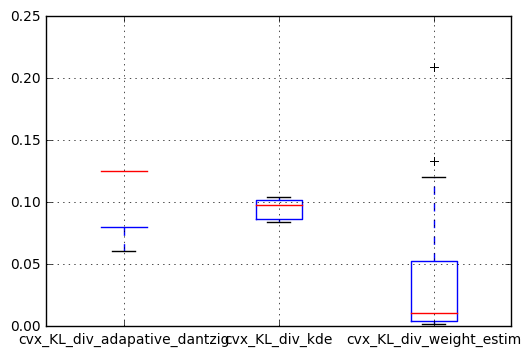

In [32]:
df_results[df_results["K"]==50].boxplot(column=["cvx_KL_div_adapative_dantzig", "cvx_KL_div_kde", "cvx_KL_div_weight_estim" ])

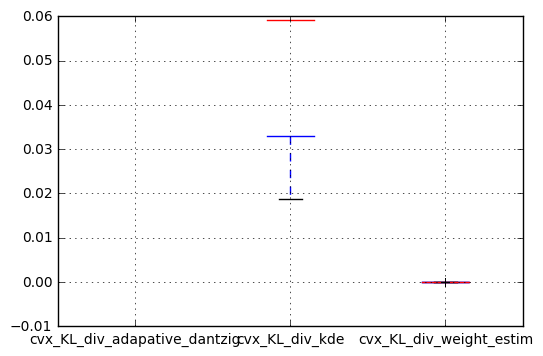

In [34]:
df_results[df_results["K"]==10].boxplot(column=["cvx_KL_div_adapative_dantzig", "cvx_KL_div_kde", "cvx_KL_div_weight_estim" ])

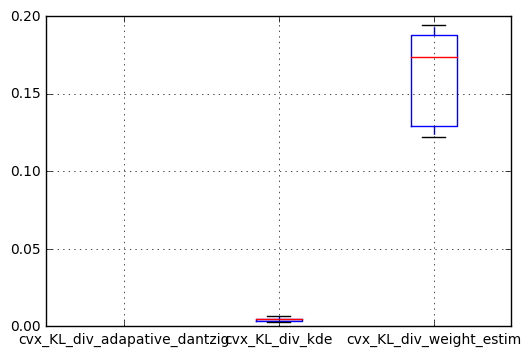

In [39]:
df = df_results[df_results["K"]==100]
df = df[df["N"]==100]
df.boxplot(column=["cvx_KL_div_adapative_dantzig", "cvx_KL_div_kde", "cvx_KL_div_weight_estim" ])

In [41]:
a = pickle.load(open("/Users/mehdi/Downloads/2017-01-14_19.37.17/res_K100N100004069c5-2bd2-44c3-b04d-e9643c2e7558"))

In [47]:
np.linalg.norm(a["cvx_weights_star"]-a["cvx_weight_vector_estim_lambda"])

ValueError: operands could not be broadcast together with shapes (50,) (35,2) 

In [45]:
a.keys()

['cvx_data',
 'cvx_adapative_dantzig',
 'cvx_f_star',
 'densities',
 'rect_adapative_dantzig',
 'uniform_data',
 'cvx_weight_vector_estim_lambda',
 'uniform_f_star',
 'uniform_weight_vector_estim_lambda',
 'rect_f_star',
 'rect_data',
 'selected_densities',
 'rect_weight_vector_estim_lambda',
 'cvx_weights_star',
 'uniform_adapative_dantzig']

In [130]:
zip(*a["cvx_weight_vector_estim_lambda"])[1]

def extract_lambda(lambda_index_tuples, K):
    lambda_ = np.zeros(K)
    index , weights = zip(*lambda_index_tuples)
    for i in range(len(index)):
        lambda_[index[i]]=weights[i]
    return lambda_

In [83]:
extract_lambda(a["cvx_weight_vector_estim_lambda"], 100)

array([ 0.        ,  0.03264022,  0.        ,  0.01091105,  0.        ,
        0.        ,  0.04076852,  0.        ,  0.        ,  0.03793594,
        0.        ,  0.        ,  0.01110045,  0.01943973,  0.        ,
        0.        ,  0.        ,  0.04035226,  0.        ,  0.        ,
        0.        ,  0.03112134,  0.        ,  0.        ,  0.03642259,
        0.        ,  0.        ,  0.03220391,  0.        ,  0.        ,
        0.        ,  0.02523606,  0.        ,  0.0200744 ,  0.        ,
        0.01579069,  0.01717958,  0.        ,  0.        ,  0.        ,
        0.02411998,  0.02646171,  0.        ,  0.        ,  0.02108504,
        0.        ,  0.        ,  0.03523746,  0.        ,  0.        ,
        0.        ,  0.03699666,  0.        ,  0.        ,  0.0144046 ,
        0.01720577,  0.        ,  0.02804349,  0.        ,  0.        ,
        0.        ,  0.01996407,  0.        ,  0.03917466,  0.        ,
        0.        ,  0.        ,  0.03384742,  0.        ,  0.  

10          Axes(0.1,0.559091;0.363636x0.340909)
50     Axes(0.536364,0.559091;0.363636x0.340909)
100             Axes(0.1,0.15;0.363636x0.340909)
dtype: object

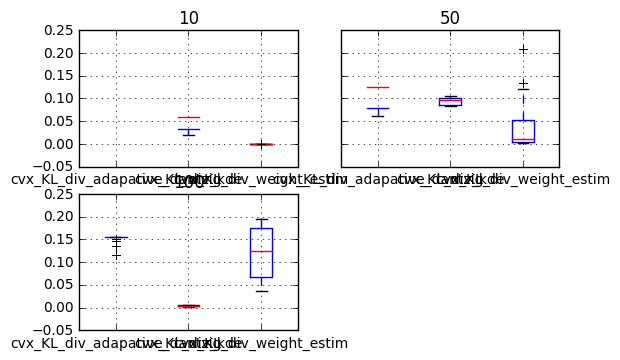

In [92]:
df_results.groupby("K").boxplot(column=["cvx_KL_div_adapative_dantzig", "cvx_KL_div_kde", "cvx_KL_div_weight_estim"])

In [95]:
import seaborn as sns

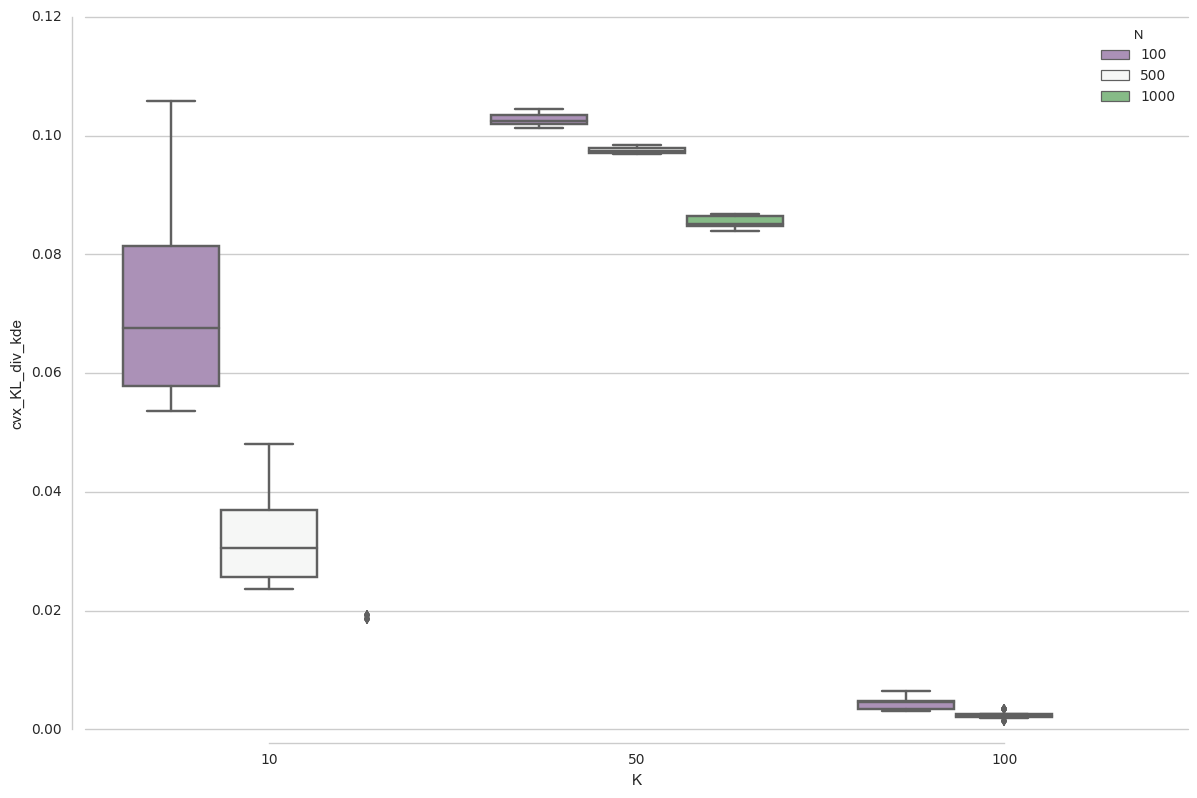

In [121]:
import seaborn as sns
sns.set_style("whitegrid")
sns.factorplot(kind='box',        # Boxplot
               y="cvx_KL_div_kde",       # Y-axis - values for boxplot
               x="K",        # X-axis - first factor
               hue="N",         # Second factor denoted by color
               data=df_results,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False,
              palette="PRGn")
sns.despine(offset=10, trim=True)  # Make legend inside the plot

In [109]:
df_results[["cvx_KL_div_adapative_dantzig", "cvx_KL_div_kde", "cvx_KL_div_weight_estim"]]

,cvx_KL_div_adapative_dantzig,cvx_KL_div_kde,cvx_KL_div_weight_estim
0,inf,0.059140,2.765857e-15
0,inf,0.079348,1.585546e-15
0,inf,0.088196,3.736127e-16
0,inf,0.053637,1.358230e-16
0,inf,0.088196,3.736127e-16
0,inf,0.054459,4.154842e-18
0,inf,0.053637,1.358230e-16
0,inf,0.087603,3.079519e-17
0,inf,0.053637,1.358230e-16
0,inf,0.067661,1.137051e-15


In [111]:
tips = sns.load_dataset("tips")

In [112]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [144]:
a = pickle.load(open("/Users/mehdi/Downloads/2017-01-18_12.53.28/res_K10N10000a611f2-a85b-40cd-9878-d70c0b7de58b"))["selected_densities"]

In [143]:
def cvx_lambda_f_star(K, selected_densities):
    lambda_ = np.zeros(K)
    for i in selected_densities:
        lambda_[i]= 1./len(selected_densities)
    return lambda_

In [145]:
cvx_lambda_f_star(10, a)

array([ 0.2,  0. ,  0.2,  0. ,  0.2,  0. ,  0.2,  0. ,  0.2,  0. ])

In [146]:
a

[0, 2, 4, 6, 8]